In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier

## Goal: predict customers to convert

Using the csv file below, we will do some exploration and data analysis before building a model that will predict whether a customer converts or not.

In [2]:
data = pd.read_csv('./conversion_data.csv')
print("There are %d rows in the csv " %(data.shape[0]))
data.head()

There are 316200 rows in the csv 


,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [3]:
#Print a concise summary of a DataFrame.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [4]:
# Generate descriptive statistics that summarize the central tendency, 
# dispersion and shape of a dataset’s distribution, excluding NaN values.
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


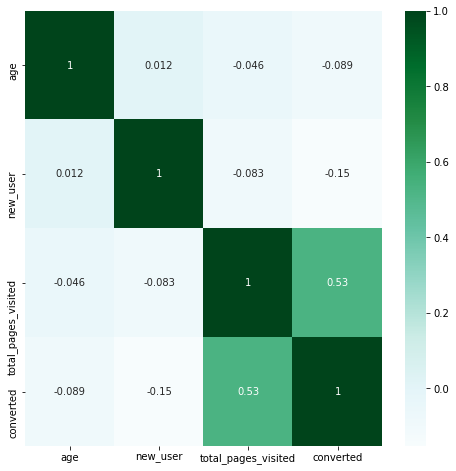

In [5]:
# Plot the heatmap to see if there are any feature are correlated
# total_pages_visited and converted are highly correlated
plt.figure(figsize=(8,8))
sns.heatmap(data.corr(), cmap='BuGn', annot=True)

In [6]:
# For each column of the dataframe, we want to know numbers of unique attributes and the attributes values.
for column in data.columns:
    unique_attribute = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(unique_attribute)), unique_attribute[:10])
    

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
converted                2	 [0, 1]


## Exploratory Analysis

In [7]:
# Check numbers of missing values per column
print(data.isnull().sum())
print("There is no missing values in this dataset")

country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64
There is no missing values in this dataset


## Data Preprocessing

In [8]:
## Perform one-hot encoding on country, source, new user
dummy = pd.get_dummies(data[['country', 'source']], drop_first = True)
data.drop(['country','source'], 1, inplace=True)
data = data.join(dummy)
data.head()

,age,new_user,total_pages_visited,converted,country_Germany,country_UK,country_US,source_Direct,source_Seo
0,25,1,1,0,0,1,0,0,0
1,23,1,5,0,0,0,1,0,1
2,28,1,4,0,0,0,1,0,1
3,39,1,5,0,0,0,0,0,1
4,30,1,6,0,0,0,1,0,1


In [9]:
#  
y = data['converted'].values
X = data.drop('converted', axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)


## Logistic Regression

In [10]:
## Set up the hyperparameter tunning
param_range = [0.0001, 0.001, 0.01, 0.1, 1]
param_grid = [{'penalty': ('l1', 'l2'),
             'C': param_range}]

In [11]:
# grid search
gs = GridSearchCV(estimator=LogisticRegression(max_iter=1000),param_grid=param_grid, cv=10, scoring='roc_auc')
gs = gs.fit(X_train, y_train)
gs

GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'penalty': ('l1', 'l2'), 'C': [0.0001, 0.001, 0.01, 0.1, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [12]:
print("Model best score: %f" %gs.best_score_)
print("model best parameters: " + str(gs.best_params_))

Model best score: 0.986098
model best parameters: {'C': 1, 'penalty': 'l1'}


In [13]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test Accuracy: %.5f' %clf.score(X_test, y_test))

Test Accuracy: 0.98623


In [14]:
# Check out classification report, recall seems to be low

y_predict = clf.predict(X_test)
print(classification_report(y_true = y_test, y_pred=y_predict))


             precision    recall  f1-score   support

          0       0.99      1.00      0.99    101065
          1       0.84      0.69      0.76      3281

avg / total       0.99      0.99      0.99    104346



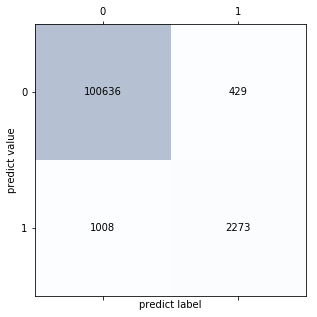

In [15]:
# plot confusion matrix
confmat = confusion_matrix(y_test, y_predict)
fig, ax = plt.subplots(figsize = (5,5))
ax.matshow(confmat, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i,
               s = confmat[i,j],
               va='center', ha='center')
plt.xlabel('predict label')
plt.ylabel('predict value')


In [16]:
1013/(1013+100643.),2273/(2273+1008.), 2273/(2273+429.)

(0.009964979932320768, 0.6927765925022858, 0.8412287194670615)

Area under the Receiver Operating Characteristic Curves (ROC AUC) is 0.844266 


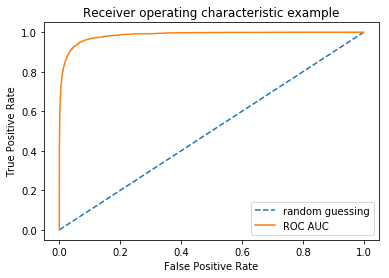

In [17]:
# ROC AUC curve
y_pred_prob = clf.predict_proba(X_test)
## assuming the label of the positive class is 1
fpr, tpr, threshold = roc_curve(y_test, y_pred_prob[:, 1], pos_label=1)


print("Area under the Receiver Operating Characteristic Curves (ROC AUC) is %f " %(roc_auc_score(y_test, y_predict)))
plt.figure()
plt.plot([0,1],[0,1], linestyle = '--', label = 'random guessing')
plt.plot(fpr, tpr, label = "ROC AUC" )
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right')


## Decision Tree Classifier

In [18]:
## Set up the hyperparameter tunning
param_range = [2, 3, 4, 5, 6]
param_grid = [{'criterion': ('gini', 'entropy'),
             'max_depth': param_range}]

In [19]:
gs2 = GridSearchCV(estimator=DecisionTreeClassifier(random_state=1),param_grid=param_grid, cv=10, scoring='roc_auc')
gs2 = gs2.fit(X_train, y_train)
gs2

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'criterion': ('gini', 'entropy'), 'max_depth': [2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [20]:
print("Model best score: %f"%gs2.best_score_)
print("model best parameters: " + str(gs2.best_params_))

Model best score: 0.981002
model best parameters: {'criterion': 'entropy', 'max_depth': 6}


In [21]:
clf2 = gs2.best_estimator_
clf2.fit(X_train, y_train)
print(gs2.best_params_)
print('Test Accuracy: %.5f' %clf2.score(X_test, y_test))

{'criterion': 'entropy', 'max_depth': 6}
Test Accuracy: 0.98505


In [22]:
# Check out classification report, recall seems to be low

y_predict2 = clf2.predict(X_test)
print(classification_report(y_true = y_test, y_pred=y_predict2))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    101065
          1       0.82      0.67      0.74      3281

avg / total       0.98      0.99      0.98    104346



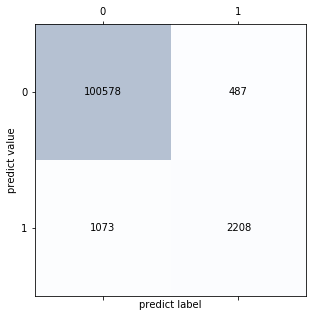

In [23]:
# plot confusion matrix
confmat2 = confusion_matrix(y_test, y_predict2)
fig, ax = plt.subplots(figsize = (5,5))
ax.matshow(confmat2, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat2.shape[0]):
    for j in range(confmat2.shape[1]):
        ax.text(x=j, y=i,
               s = confmat2[i,j],
               va='center', ha='center')
plt.xlabel('predict label')
plt.ylabel('predict value')

In [24]:
# Feature Importance
fimport = data.columns.drop('converted')
fimport
feature_importances2 = pd.DataFrame(clf2.feature_importances_,
                                   index = fimport,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances2


,importance
total_pages_visited,0.927167
new_user,0.050862
age,0.019678
country_UK,0.001566
country_US,0.000353
source_Seo,0.000268
country_Germany,0.000105
source_Direct,0.000000


## Random Forest Classifier

In [25]:
## Set up the hyperparameter tunning
#param_range = [2, 3, 4, 5, 6]
param_grid = [{'criterion': ('gini', 'entropy')}]

In [26]:
gs3 = GridSearchCV(estimator=RandomForestClassifier(random_state=1),param_grid=param_grid, cv=10, scoring='roc_auc')
gs3 = gs3.fit(X_train, y_train)
gs3

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'criterion': ('gini', 'entropy')}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [27]:
print("Model best score: %f"%gs3.best_score_)
print("model best parameters: " + str(gs3.best_params_))

Model best score: 0.937914
model best parameters: {'criterion': 'entropy'}


In [28]:
clf3 = gs3.best_estimator_
clf3.fit(X_train, y_train)
print(gs3.best_params_)
print('Test Accuracy: %.5f' %clf3.score(X_test, y_test))

{'criterion': 'entropy'}
Test Accuracy: 0.98426


In [29]:
# Check out classification report, recall seems to be low

y_predict3 = clf3.predict(X_test)
print(classification_report(y_true = y_test, y_pred=y_predict3))

             precision    recall  f1-score   support

          0       0.99      0.99      0.99    101065
          1       0.80      0.67      0.73      3281

avg / total       0.98      0.98      0.98    104346



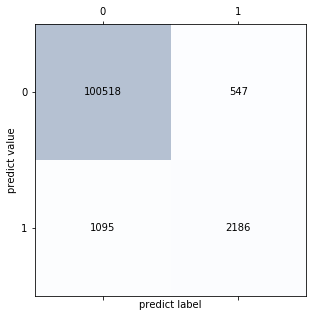

In [30]:
# plot confusion matrix
confmat3 = confusion_matrix(y_test, y_predict3)
fig, ax = plt.subplots(figsize = (5,5))
ax.matshow(confmat3, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat3.shape[0]):
    for j in range(confmat3.shape[1]):
        ax.text(x=j, y=i,
               s = confmat3[i,j],
               va='center', ha='center')
plt.xlabel('predict label')
plt.ylabel('predict value')

In [31]:
feature_importances3 = pd.DataFrame(clf3.feature_importances_,
                                   index = fimport,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances3

,importance
total_pages_visited,0.761512
age,0.111422
new_user,0.075854
country_US,0.016822
country_UK,0.015655
country_Germany,0.009118
source_Seo,0.005486
source_Direct,0.004131


## Gradient Boosting Classifier

In [32]:
## Set up hyperparameter tuning
estimator_range = [10]
depth_range = [10]
param_grid = [{'n_estimators':estimator_range, 
              'max_depth': depth_range}]



In [33]:
gs4 = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=param_grid, cv=3, scoring='roc_auc')
gs4 = gs4.fit(X_train, y_train)
gs4

GridSearchCV(cv=3, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10], 'max_depth': [10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [34]:
print("Model best score: %f"%gs4.best_score_)
print("model best parameters: " + str(gs4.best_params_))

Model best score: 0.972458
model best parameters: {'max_depth': 10, 'n_estimators': 10}


In [35]:
clf4 = gs4.best_estimator_
clf4.fit(X_train, y_train)
print(gs4.best_params_)
print('Test Accuracy: %.5f' %clf4.score(X_test, y_test))

{'max_depth': 10, 'n_estimators': 10}
Test Accuracy: 0.98478


In [36]:
# Check out classification report, recall seems to be low

y_predict4 = clf4.predict(X_test)
print(classification_report(y_true = y_test, y_pred=y_predict4))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99    101065
          1       0.86      0.61      0.72      3281

avg / total       0.98      0.98      0.98    104346



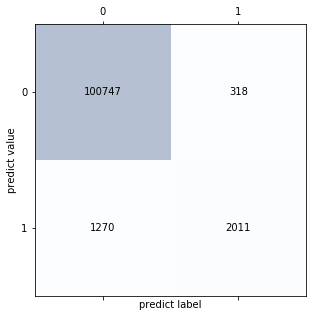

In [37]:
# plot confusion matrix
confmat4 = confusion_matrix(y_test, y_predict4)
fig, ax = plt.subplots(figsize = (5,5))
ax.matshow(confmat4, cmap = plt.cm.Blues, alpha = 0.3)
for i in range(confmat4.shape[0]):
    for j in range(confmat4.shape[1]):
        ax.text(x=j, y=i,
               s = confmat4[i,j],
               va='center', ha='center')
plt.xlabel('predict label')
plt.ylabel('predict value')

In [38]:
# Feature Importance
feature_importances4 = pd.DataFrame(clf4.feature_importances_,
                                   index = fimport,
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances4

,importance
total_pages_visited,0.802478
age,0.069066
new_user,0.059785
country_Germany,0.018305
country_US,0.015654
country_UK,0.014322
source_Seo,0.011627
source_Direct,0.008763


## Summary

In [41]:
#Summary
clf_labels = ['Logistic regression', 'Decision tree Classifier', 'Random Forest Classifier']
print('10-fold cross validation Summary:\n')

for clf, label in zip([clf, clf2, clf3, clf4], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"% (scores.mean(), scores.std(), label))

10-fold cross validation Summary:

ROC AUC: 0.99 (+/- 0.00) [Logistic regression]
ROC AUC: 0.98 (+/- 0.00) [Decision tree Classifier]
ROC AUC: 0.94 (+/- 0.01) [Random Forest Classifier]
